In [10]:
# 库文件
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split

import numpy as np
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
#差分方程  # 生成数据
def nonlinear_system(y1_k, y2_k, u1_k, u2_k, u1_k_1, u2_k_1):
    # 生成噪声
    noise_level = 0.01
    noise1 = np.random.normal(loc=0, scale=np.sqrt(noise_level))
    noise2 = np.random.normal(loc=0, scale=np.sqrt(noise_level))
    # 计算输出
    output1 = y1_k / (1 + y2_k**2) + u1_k + 0.2 * u2_k + 0.4 * u1_k_1 + 0.1 * u2_k_1 + noise1
    output2 = y1_k * y2_k / (1 + y2_k**2) + 0.3 * u1_k + u2_k + 0.1 * u1_k_1 + 0.5 * u2_k_1 + noise2
    return output1, output2


# 参数设置
num_samples = 300
y1_data, y2_data = np.zeros(num_samples), np.zeros(num_samples)

# 初始化初始条件
y1_data[0], y2_data[0] = 1.0, 0.5

# 生成输入数据在[-1, 1]之间
u1_data = np.random.uniform(-1, 1, num_samples)
u2_data = np.random.uniform(-1, 1, num_samples)
u1_data_1 = np.roll(u1_data, 1)
u2_data_1 = np.roll(u2_data, 1)
u1_data_1[0], u2_data_1[0] = 0, 0  # 设置第一个时刻的上一个时刻输入为0

# 生成数据
for k in range(1, num_samples):
    y1_data[k], y2_data[k] = nonlinear_system(y1_data[k-1], y2_data[k-1], u1_data[k], u2_data[k], u1_data_1[k], u2_data_1[k])

print()

In [3]:
#组合训练数据  多输入单输出
# 假设有训练数据 u1_data, u2_data, y1_data_1 和 y1_data
# 将它们组合成输入特征矩阵 X 和输出标签向量 y
u1_data_1 = np.roll(u1_data, 1)
u2_data_1 = np.roll(u2_data, 1)
u1_data_1[0], u2_data_1[0] = 0, 0
y1_data_1 = np.roll(y1_data, 1)
y1_data_1[0] = 0.3
X = np.column_stack((u1_data, u2_data, u1_data_1, u2_data_1, y1_data_1))
y = y1_data
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3333, random_state=42)


In [4]:
# 定义My_LS_SVRModel

class My_LS_SVRModel:
    def __init__(self, params):
        self.C = params[0]
        self.gamma = params[1]
        self.W_b = None
        self.X_train = None

    def model_train(self, X_train, y_train, K_train):
        def objective(W_b, X, y, C):
            y_pred = np.dot(K_train, W_b[:-1]) + W_b[-1]
            errors = y - y_pred
            loss = 0.5 * np.dot(W_b[:-1], W_b[:-1]) + C * np.sum(errors**2)
            return loss

        initial_W_b = np.zeros(X_train.shape[0] + 1)
        result = minimize(objective, initial_W_b, args=(X_train, y_train, self.C), method='L-BFGS-B')
        best_W_b = result.x
        return best_W_b

    def fit(self, X_train, y_train):
        self.X_train = X_train
        K_train = rbf_kernel(X_train, X_train, gamma=self.gamma)
        self.W_b = self.model_train(X_train, y_train, K_train)

    def predict(self, X_test):
        K_test = rbf_kernel(X_test, self.X_train, gamma=self.gamma)
        y_pred = np.dot(K_test, self.W_b[:-1]) + self.W_b[-1]
        return y_pred
    

# # 示例用法
# params = [8.78525340e+01, 2.01347249e-03]
# # 创建模型
# my_svr_model = My_LS_SVRModel(params=params)
# # 训练模型
# my_svr_model.fit(X_train, y_train)
# # 模型预测
# y_pred = my_svr_model.predict(X_test)

In [6]:
# 使用粒子群优化

def initialize_particles(Particle_num, params_num, Xmin, Xmax, Vmin, Vmax):
    # 初始化粒子群的位置和速度
    positions = np.random.uniform(Xmin, Xmax, size=(Particle_num, params_num))
    # plt.plot(positions[:,0],positions[:,1])
    velocities = np.random.uniform(Vmin, Vmax, size=(Particle_num, params_num))
    return positions, velocities
def evaluate_fitness(positions, fitness_values, X_train, y_train, X_test, y_test):
    # 在这里计算适应值（均方根误差）
    fitness_values = your_fitness_function(positions, fitness_values, X_train, y_train, X_test, y_test)
    return fitness_values
def update_personal_best(personal_best_positions, personal_best_fitness, positions, fitness_values):
    # 对每个粒子进行循环
    for i in range(len(positions)):
        # 如果当前适应值更好，则更新个体最佳位置和适应值
        if fitness_values[i] < personal_best_fitness[i]:
            personal_best_positions[i] = positions[i].copy()
            personal_best_fitness[i] = fitness_values[i]
    return personal_best_positions, personal_best_fitness
def update_global_best(global_best_position, global_best_fitness, personal_best_positions, personal_best_fitness):
    # 找到所有粒子中适应值最好的粒子的索引
    best_particle_index = np.argmin(personal_best_fitness)
    # 如果该粒子的适应值更好，则更新全局最佳位置和适应值
    if personal_best_fitness[best_particle_index] < global_best_fitness:
        global_best_position[:] = personal_best_positions[best_particle_index].copy()
        global_best_fitness = personal_best_fitness[best_particle_index]
    return global_best_position,global_best_fitness
def update_particles(iteration, iterations_max, positions, velocities, personal_best_positions, global_best_position, 
                    c1, c2, Xmin, Xmax, Vmin, Vmax):
    # 更新粒子的速度和位置
    r1 = np.random.rand(*positions.shape)
    r2 = np.random.rand(*positions.shape)

    w_max = 0.9
    w_min = 0.4
    weight = w_max - iteration*(w_max-w_min)/iterations_max
    # weight = 1
    velocities = weight * velocities + c1 * r1 * (personal_best_positions - positions) + c2 * r2 * (global_best_position - positions)
    # 限制速度范围
    velocities = np.clip(velocities, Vmin, Vmax)
    # 更新位置
    positions = positions + velocities
    # 限制位置范围
    positions = np.clip(positions, Xmin, Xmax)

    return positions, velocities
def pso_algorithm(Particle_num, Xmin, Xmax, Vmin, Vmax, iterations_max, params_num, C1, C2, tao, X_train, y_train, X_test, y_test):
    # 初始化粒子群
    positions, velocities = initialize_particles(Particle_num, params_num, Xmin, Xmax, Vmin, Vmax)

    # 初始化每个粒子的个体最佳位置和适应值
    personal_best_positions = positions.copy()
    personal_best_fitness = np.full(Particle_num, np.inf)#所有元素的值都设置为正无穷
    
    # 初始化全局最佳位置和适应值
    global_best_position = np.zeros(params_num)
    global_best_fitness = np.inf

    fitness_values = np.zeros(Particle_num)
    # 开始迭代
    fitness_values_list = []  # 用于存储每次迭代后的最佳适应值
    for iteration in range(iterations_max):
        print('iteration',iteration)
        # 计算每个粒子的适应值
        fitness_values = evaluate_fitness(positions, fitness_values, X_train, y_train, X_test, y_test)
        
        # 更新个体最佳位置和适应值
        personal_best_positions, personal_best_fitness = update_personal_best(personal_best_positions, personal_best_fitness, positions, fitness_values)
        
        # 更新全局最佳位置和适应值
        global_best_position,global_best_fitness = update_global_best(global_best_position, global_best_fitness, personal_best_positions, personal_best_fitness)
        print(global_best_position,global_best_fitness)
        # 更新粒子的速度和位置
        positions, velocities = update_particles(iteration, iterations_max,positions, velocities, personal_best_positions, global_best_position, C1, C2, Xmin, Xmax, Vmin, Vmax)
        
        # 记录适应度值
        fitness_values_list.append(global_best_fitness)
        
        # 检查收敛精度
        if global_best_fitness < tao:
            break

    # 返回最终的全局最佳位置和适应值
    return global_best_position, global_best_fitness, fitness_values_list
# 替换为你实际的目标函数
def your_fitness_function(positions, fitness_values, X_train, y_train, X_test, y_test):
    for i in range(len(positions)):
        print('i',i)
        
        # 示例用法
        params = positions[i]
        # 创建模型
        my_svr_model = My_LS_SVRModel(params=params)
        # 训练模型
        my_svr_model.fit(X_train, y_train)
        # 模型预测
        y_pred = my_svr_model.predict(X_test)        

        # 在这里计算适应值（均方根误差）
        errors = y_test - y_pred
        mse = np.sqrt(np.sum(errors**2)/X_test.shape[0])

        fitness_values[i] = mse

    return fitness_values



# position = [C gamma]
# 调用粒子群算法
vel = 1
Xmin = [0,0]
Xmax=[100,10]
result_position, result_fitness, fitness_values_list = pso_algorithm(Particle_num = 5, Xmin=Xmin, Xmax=Xmax, Vmin=-vel, Vmax=vel, 
                                                iterations_max=10, params_num = 2, C1=2, C2=2, tao=0.1, 
                                                X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

# 输出结果
print(f"Global Best Position: {result_position}")
print(f"Global Best Fitness: {result_fitness}")



params = result_position
# params = [3.39645507e+01 3.39715885e-03]
# 创建模型
my_svr_model = My_LS_SVRModel(params=params)
# 训练模型
my_svr_model.fit(X_train, y_train)
# 模型预测
y_pred = my_svr_model.predict(X_test)        



iteration 0
i 0
i 1
i 2
i 3
i 4
[33.33144111  0.26357587] 0.33582998856638885
iteration 1
i 0
i 1
i 2
i 3
i 4
[33.33144111  0.26357587] 0.33582998856638885
iteration 2
i 0
i 1
i 2
i 3
i 4
[33.33144111  0.26357587] 0.33582998856638885
iteration 3
i 0
i 1
i 2
i 3
i 4
[32.83308485  0.10392383] 0.3037534657504101
iteration 4
i 0
i 1
i 2
i 3
i 4
[3.31801041e+01 5.18095064e-03] 0.2850810251193565
iteration 5
i 0
i 1
i 2
i 3
i 4
[3.31801041e+01 5.18095064e-03] 0.2850810251193565
iteration 6
i 0
i 1
i 2
i 3
i 4
[3.35929796e+01 3.76139632e-03] 0.28400120507210896
iteration 7
i 0
i 1
i 2
i 3
i 4
[3.35929796e+01 3.76139632e-03] 0.28400120507210896
iteration 8
i 0
i 1
i 2
i 3
i 4
[3.39645507e+01 3.39715885e-03] 0.283832998000739
iteration 9
i 0
i 1
i 2
i 3
i 4
[3.39645507e+01 3.39715885e-03] 0.283832998000739
Global Best Position: [3.39645507e+01 3.39715885e-03]
Global Best Fitness: 0.283832998000739


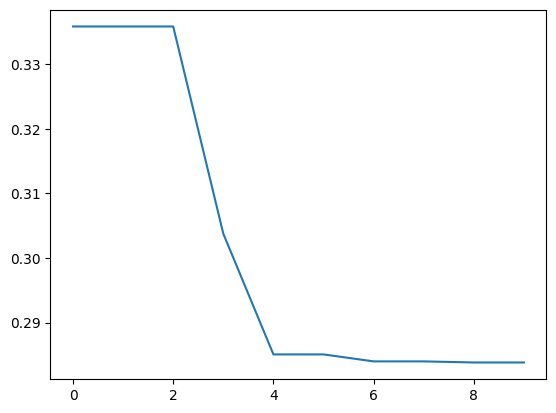

In [8]:
plt.plot(fitness_values_list)

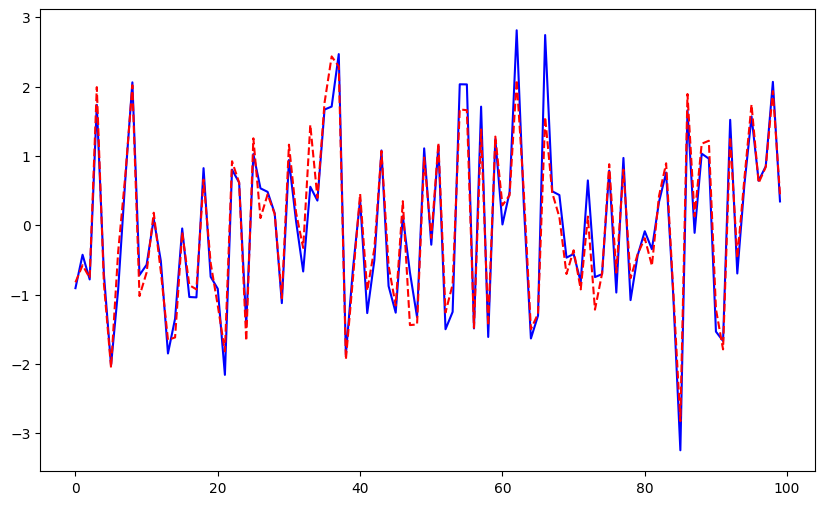

In [9]:
plt.figure(figsize=(10, 6))  
plt.plot(y_test,'b-')
plt.plot(y_pred,'r--')
# plt.plot(y_pred22,'g--')